## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


**Look up storage upperbound from scenario output**

In [2]:
storbase = message_ix.Scenario(mp, model=f'SSP_dev_SSP5_v0.1_dac', scenario="1000f_v0.13_dac-co2split_mpen5")


In [31]:
nodes = [node for node in storbase.set("node")]
years = list(sorted(set(storbase.vintage_and_active_years()["year_act"])))

# Annual CO2 stored
co2_stored = storbase.var("EMISS",
    {"emission":"CO2_storage",
    "node":[node for node in nodes if node not in ["World","R12_GLB"]],
    "type_tec":"all"}).set_index(["node","year"])["lvl"].unstack()


## Varying `SSP` and global `CO2_storage` rate

In [32]:
ssps = ["SSP1","SSP2","SSP5"]
scens = {
    "co2rate1": 0.2,
    "co2rate2": 0.4,
    "co2rate3": 0.6,
    "co2rate4": 0.8,
    "co2rate5": 1.0,
        }
max_rate = 20000

stor scenario: SSP1 co2rate1


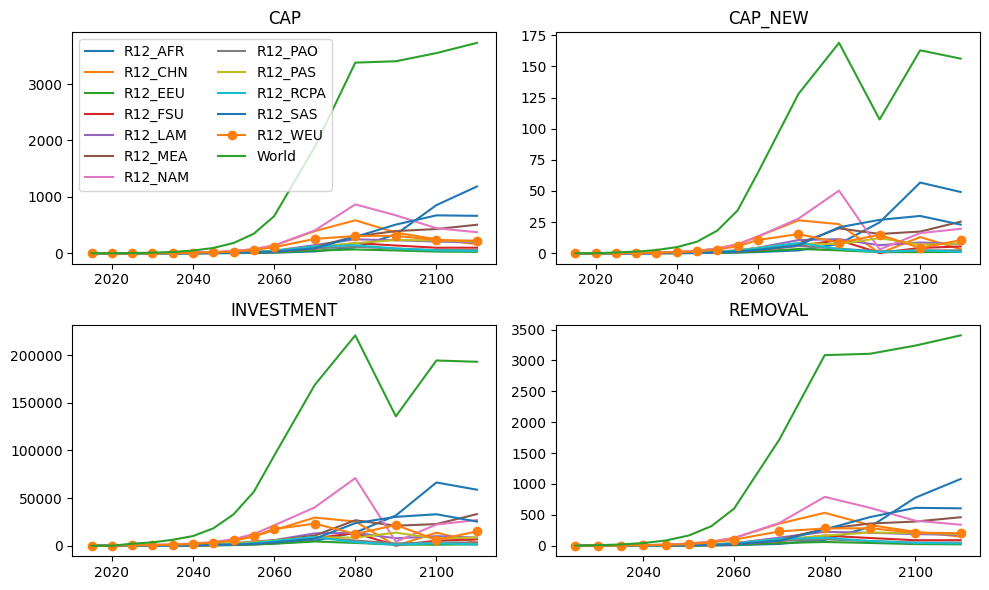

stor scenario: SSP1 co2rate2


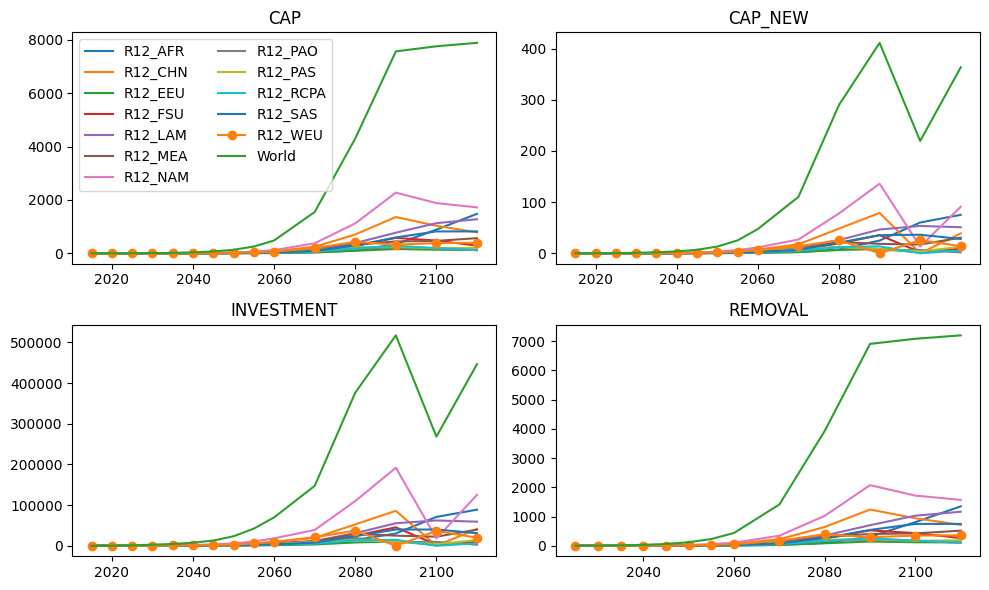

stor scenario: SSP1 co2rate3


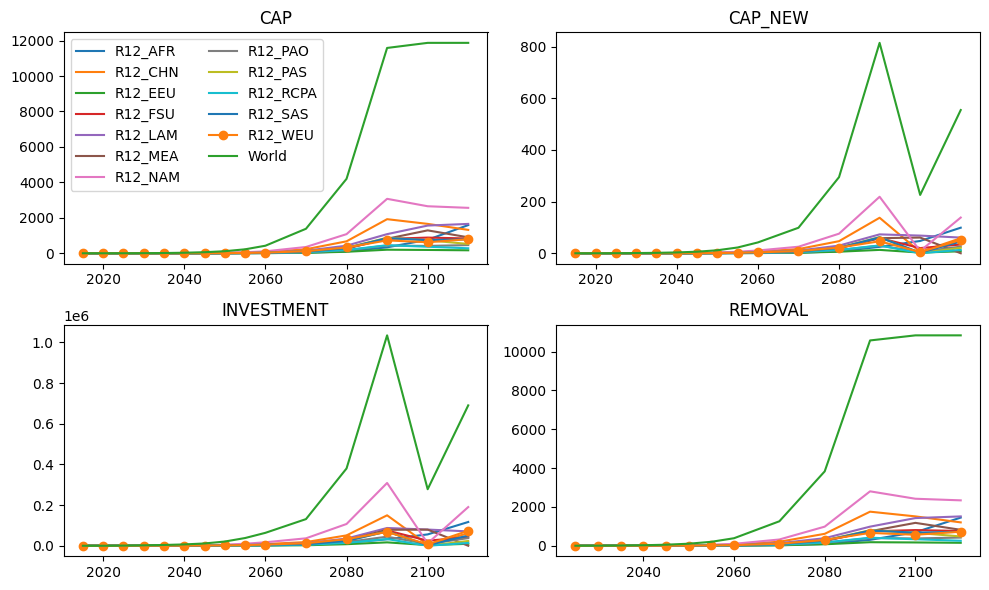

stor scenario: SSP1 co2rate4


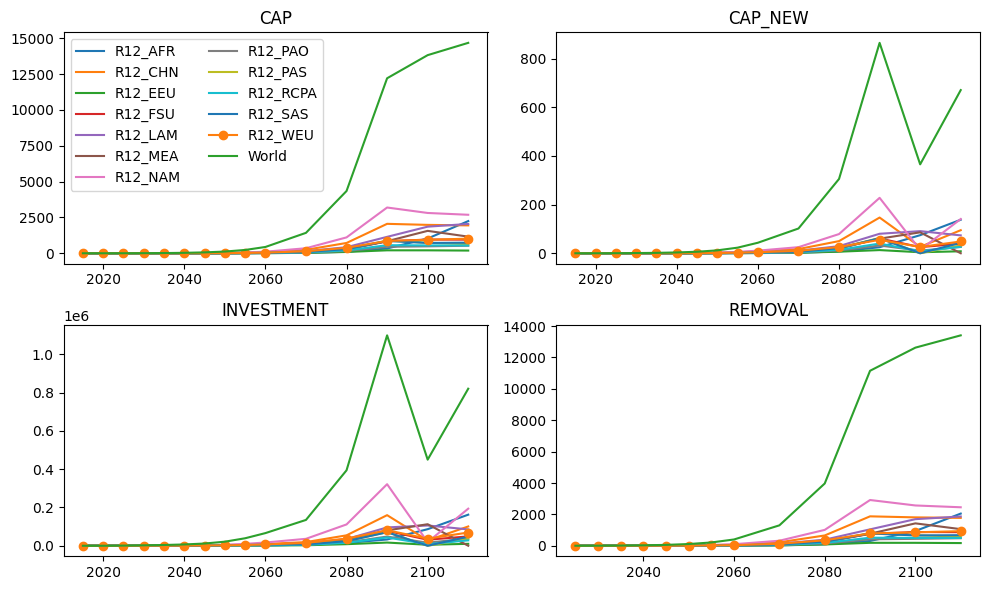

stor scenario: SSP1 co2rate5


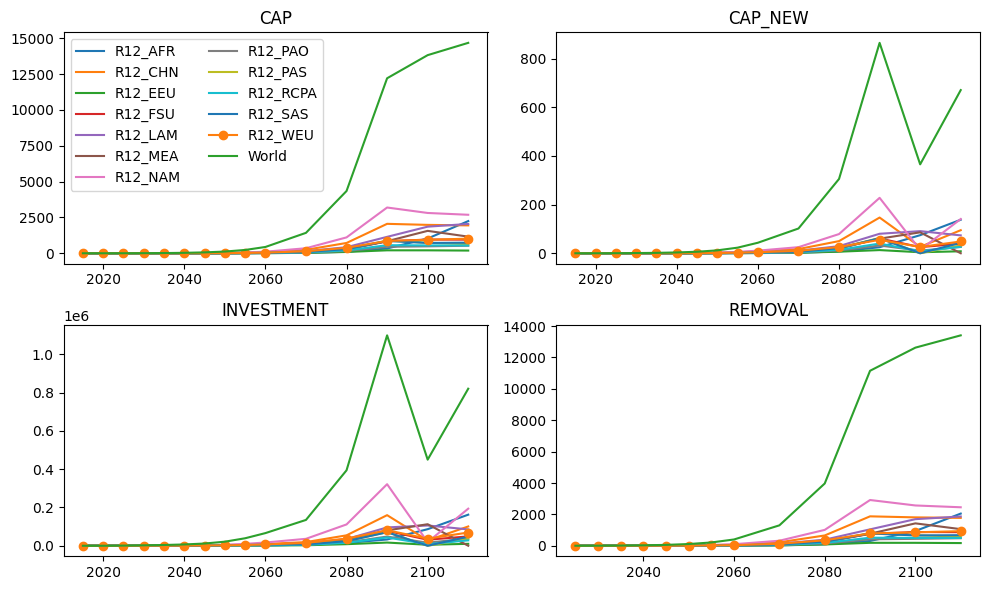

stor scenario: SSP2 co2rate1
stor scenario: SSP2 co2rate2
stor scenario: SSP2 co2rate3
stor scenario: SSP2 co2rate4
stor scenario: SSP2 co2rate5
stor scenario: SSP5 co2rate1
stor scenario: SSP5 co2rate2
stor scenario: SSP5 co2rate3
stor scenario: SSP5 co2rate4
stor scenario: SSP5 co2rate5


In [33]:
# this is to import scenario from data base and clone to local
for ssp in ssps:
    for key,val in scens.items():
        dacsspscen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="1000f_v0.13_dac-co2split")
        dacrate_scen = dacsspscen.clone(
            f"SSP_dev_{ssp}_v0.1_dac",
            f"1000f_v0.13_dac-co2split_mpen3_{key}",
            f"{ssp}_dev 1000f carbon budget with mpen3 dac, {key} co2 rate, and split CO2 transmission and disposal",
            keep_solution=False, 
        )
        dacrate_scen.check_out()
        
        # adding set up for limiting storage volume
        if "CO2_storage" not in dacrate_scen.set("emission"):
            dacrate_scen.add_set("emission", "CO2_storage")
        if "co2_stor_pot" not in dacrate_scen.set("type_emission"):
            dacrate_scen.add_set("type_emission", "co2_storage_pot")
        if "co2_potential" not in dacrate_scen.set("type_tec"):
            dacrate_scen.add_set("type_tec", "co2_potential")
        if "co2_stor" not in dacrate_scen.set("technology"):
            dacrate_scen.add_set("technology", "co2_stor")

        dacrate_scen.add_set("cat_emission", ["co2_storage_pot", "CO2_storage"])
        dacrate_scen.add_set("cat_tec", ["co2_potential", "co2_stor"])
        
        # Updating storage volume limits
        
        for year in years:
            df = make_df("bound_emission",
                         node="World",
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year=year,
                         value = (max_rate * val),
                         unit = "???",
                        )
            df_list += [df]

        dfs = pd.concat(df_list)

        
        
        df_list = []
        for year in years:
            df = make_df("bound_emission",
                         node="World",
                         type_emission="co2_storage_pot",
                         type_tec="co2_potential",
                         type_year=year,
                         value = (max_rate * val), # ultimate rate x fraction
                         unit = "???",
                        )
            df_list += [df]
        df_co2ratelim = pd.concat(df_list)
        
        dacrate_scen.add_par("bound_emission", df_co2ratelim)

        # add emission bound
        dacrate_scen.commit(comment=f"{ssp}_dev 1000f with DAC {key} scenario")
        dacrate_scen.set_as_default()

        dacrate_scen.solve(solve_options={'scaind': '1'})
        dacrate_scen.var("OBJ")["lvl"]

        # Get Report
        print("stor scenario:", ssp, key)
        if ssp == "SSP1":
            scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']
            scenario_report = get_report(dacrate_scen,scenariotec)

## Close connection

In [34]:
mp.close_db()